In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import pickle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from lightgbm import LGBMClassifier
from src.data_processor.phase_1.prob1.v1 import Phase1Prob1FeatureProcessor

In [2]:
df = pd.read_parquet("/mnt/f/Data/MLOPS_2023/data_phase-1/phase-1/prob-1/raw_train.parquet")
# test = pd.read_csv('../mlops_phase1_prob1_3c1d3675-60e5-4268-9c4c-d3de9417c49b.csv')

In [3]:
processor = Phase1Prob1FeatureProcessor()
new_df = processor.fit_transform(df)

In [4]:
kfold = StratifiedKFold(n_splits=5,random_state=42, shuffle=True)

In [5]:
FEATURES = processor.data_features['features']
categorical = processor.data_features['categorical_features']
TARGET = 'label'

In [6]:
import numpy as np

In [7]:
models = []
oofs = np.zeros(df.shape[0])
for i, (train_idx, valid_idx) in enumerate(kfold.split(new_df, df['label'])):
    X_train = new_df.iloc[train_idx][FEATURES]
    X_valid = new_df.iloc[valid_idx][FEATURES]
    y_train = df.iloc[train_idx][TARGET]
    y_valid = df.iloc[valid_idx][TARGET]
    model = LGBMClassifier(n_estimators=100,
                           learning_rate=0.05,
                           max_depth=4,
                           colsample_bytree=0.5,
                           reg_alpha=8,
                           reg_lambda=32,
                           subsample=0.8,
                           # device="gpu",
                           is_unbalance=True,
                           random_state=42)
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_valid, y_valid)],
              eval_metric=["logloss", "auc"],
              categorical_feature=categorical,
              early_stopping_rounds=50,
              verbose=50)
    models.append(model)
    y_pred_proba = model.predict_proba(X_valid)[:,1]
    oofs[valid_idx] = y_pred_proba
    y_pred = (y_pred_proba>0.5).astype(int)
    print(f"fold {i} : {roc_auc_score(y_valid, y_pred_proba)}")
    print(classification_report(y_valid, y_pred))

[50]	training's binary_logloss: 0.136885	training's auc: 0.993302	valid_1's binary_logloss: 0.140159	valid_1's auc: 0.99119
[100]	training's binary_logloss: 0.109195	training's auc: 0.99567	valid_1's binary_logloss: 0.114517	valid_1's auc: 0.992985
fold 0 : 0.992985105183237
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     25141
           1       0.63      0.95      0.76      1700

    accuracy                           0.96     26841
   macro avg       0.81      0.96      0.87     26841
weighted avg       0.97      0.96      0.96     26841

[50]	training's binary_logloss: 0.13787	training's auc: 0.993162	valid_1's binary_logloss: 0.137634	valid_1's auc: 0.992196
[100]	training's binary_logloss: 0.112028	training's auc: 0.995304	valid_1's binary_logloss: 0.114003	valid_1's auc: 0.9934
fold 1 : 0.9933997496373251
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     25140
           1

In [7]:
feats = pd.DataFrame({'features': models[0].feature_name_, 'score': models[0].feature_importances_})

In [8]:
feats.sort_values('score', ascending=False, inplace=True)

In [9]:
feats

,features,score
2,feature3,363
0,feature1,197
14,feature16,194
10,feature11,172
1,feature2,161
12,feature13,69
11,feature12,46
9,feature10,37
6,feature7,16
3,feature4,10


In [10]:
gmodel = LGBMClassifier(**models[0].get_params())
gmodel.fit(new_df[FEATURES], df[TARGET],
          eval_set=[(new_df[FEATURES],df[TARGET])],
          eval_metric=["logloss", "auc"],
          categorical_feature=categorical,
          verbose=50)

[50]	valid_0's binary_logloss: 0.137098	valid_0's auc: 0.993065
[100]	valid_0's binary_logloss: 0.111048	valid_0's auc: 0.995356


LGBMClassifier(colsample_bytree=0.5, is_unbalance=True, learning_rate=0.05,
               max_depth=4, random_state=42, reg_alpha=8, reg_lambda=32,
               subsample=0.8)

In [11]:
with open('../checkpoints/phase-1/prob-1/v1.pkl','wb') as file:
    pickle.dump(gmodel, file)

In [19]:
from sklearn.metrics import f1_score, accuracy_score
scores = []; thresholds = []
best_score = 0; best_threshold = 0
train_labels = df['label']
for threshold in np.arange(0.3,0.9,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oofs>=threshold).astype('int')
    m = f1_score(train_labels, preds, average='macro')
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

0.30, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.90, 

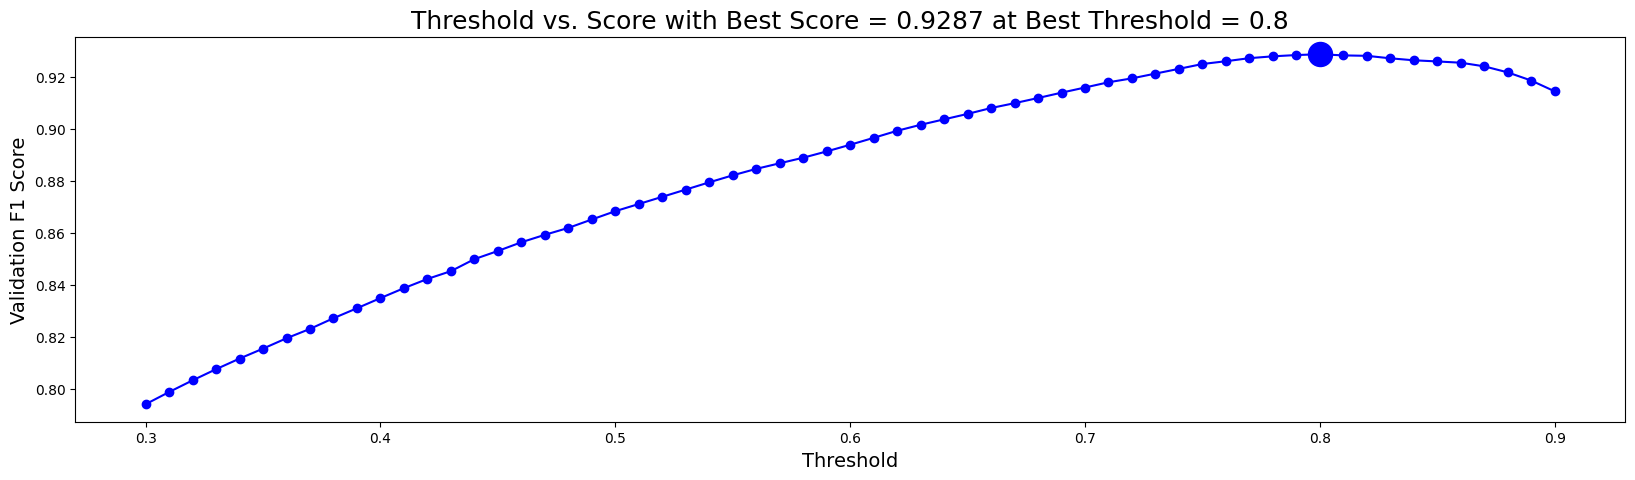

In [20]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. Score with Best Score = {best_score:.4f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()